In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
from data_reader_writer import data_writer

import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

## Low capacity, low network, and high demand - 2030

In [3]:
# scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
scenario = 'System Transformation'
# scenario = 'Steady Progression'
year = 2030
year_baseline = 2012

start = str(year) + '-12-04 20:00:00'
end = str(year) + '-12-10 20:00:00'
# time step as fraction of hour
time_step = 1
data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
            scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [4]:
import add_P2G
add_P2G.add_P2G(year, scenario=scenario)

In [5]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data_P2G')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon Penwortham', 'Tidal lagoon S.W.Penisula',
       'Tidal stream Deeside', 'Tidal stream Harker', 'Tidal stream Lovedean',
       'Tidal stream Melksham', 'Tidal stream Penwortham',
       'Tidal stream S.W.Penisula', 'Wave power Beauly', 'Wave power Melksham',
       'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data_P2G has buses, generators, lines, links, loads, storage_units


In [6]:
# scale the B6 lines to system transformation economy RT
B6 = network.lines.at['17', 's_nom'] + network.lines.at['18', 's_nom'] + network.lines.at['23', 's_nom'] + network.lines.at['24', 's_nom'] + network.lines.at['16', 's_nom']
# network.lines
scaling_factor = 24666 / B6
network.lines.s_nom *= scaling_factor
# scale the lines to zero
network.lines.at['17', 's_nom'] = 0
network.lines.at['18', 's_nom'] = 0
network.lines.at['23', 's_nom'] = 0
network.lines.at['24', 's_nom'] = 0
network.lines.at['16', 's_nom'] = 0

In [7]:
# derate CCS gas to 0% of capacity across Scotland
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'CCS Gas'), "p_nom"] *= 0.
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'Natural Gas'), "p_nom"] *= 0.

In [8]:
# derate hydrogen to 0% of capacity across Scotland
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'Hydrogen'), "p_nom"] *= 0.

In [9]:
# scale up loads according to Consumer Transformation peak demand
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_loads_scotland = network.loads[network.loads.bus.isin(buses_scotland)]
network.loads_t.p_set.loc[:, buses_scotland].sum(axis=1).max()

peak_demand_data = {'2021': 4600 ,
                    '2030': 5900,
                    '2035': 8000,
                    '2040': 10200,
                    '2045': 11300}
unscaled_peak = network.loads_t.p_set[buses_scotland].sum(axis=1).max()
load_scale = peak_demand_data[str(year)] / unscaled_peak

network.loads_t.p_set.loc[:, buses_scotland] *= load_scale

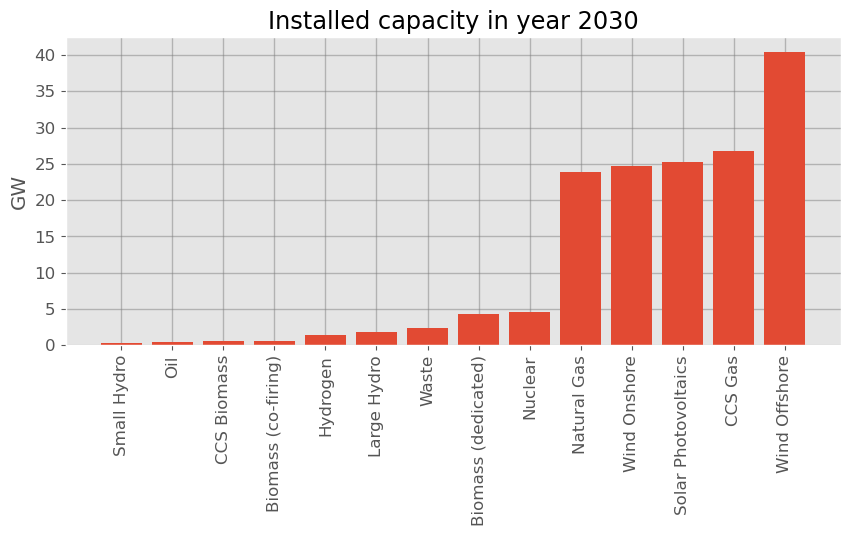

In [10]:
generators_p_nom = network.generators.p_nom.groupby(
    network.generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
plt.xticks(generators_p_nom.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year))
plt.show()

In [11]:
generators_p_nom

carrier
Small Hydro              243.436493
Oil                      386.520000
CCS Biomass              549.999996
Biomass (co-firing)      612.000000
Hydrogen                1376.776481
Large Hydro             1857.769500
Waste                   2389.677000
Biomass (dedicated)     4270.170000
Nuclear                 4570.000000
Natural Gas            23882.269100
Wind Onshore           24669.330000
Solar Photovoltaics    25207.770000
CCS Gas                26738.765293
Wind Offshore          40438.970000
Name: p_nom, dtype: float64

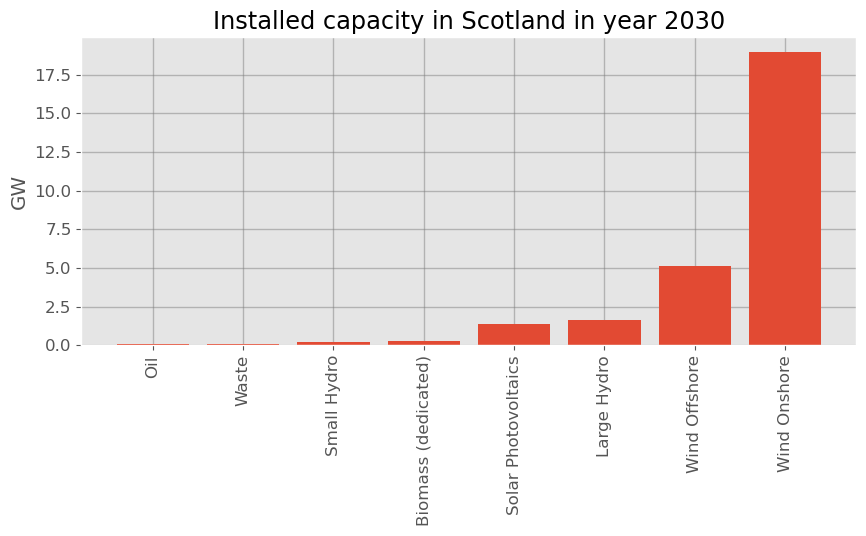

In [12]:
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]

generators_p_nom_scotland = df_generators_scotland.p_nom.groupby(
    df_generators_scotland.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom_scotland.drop('Unmet Load', inplace=True)
generators_p_nom_scotland.drop(generators_p_nom_scotland[generators_p_nom_scotland < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom_scotland.index, generators_p_nom_scotland.values / 1000)
plt.xticks(generators_p_nom_scotland.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in Scotland in year ' + str(year))
plt.show()

In [13]:
generators_p_nom_scotland

carrier
Oil                       55.200000
Waste                     82.128000
Small Hydro              222.628043
Biomass (dedicated)      250.672326
Solar Photovoltaics     1400.126320
Large Hydro             1631.002146
Wind Offshore           5136.090000
Wind Onshore           18978.428676
Name: p_nom, dtype: float64

In [14]:
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]
storage_by_carrier_scotland = df_storage_scotland.p_nom.groupby(df_storage_scotland.carrier).sum()
storage_by_carrier_scotland

carrier
Battery                         1771.443400
Compressed Air                     0.910345
Liquid Air                        42.675862
P2G                             1343.726561
Pumped Storage Hydroelectric     740.000000
Name: p_nom, dtype: float64

In [15]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.73s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-qtrwgdqy.lp
Reading time = 0.92 seconds
obj: 413858 rows, 129631 columns, 726966 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 413858 rows, 129631 columns and 726966 nonzeros
Model fingerprint: 0x0b5e368d
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 5e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 389356 rows and 46270 columns
Presolve time: 0.40s
Presolved: 24502 rows, 83793 columns, 156022 nonzeros

Ordering time: 0.25s

Barrier statist

INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e+07


('ok', 'optimal')

In [24]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})

p_by_carrier

carrier,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,Coal,Hydrogen,Hydro,Natural Gas,Nuclear,Oil,...,Waste,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,P2G,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2030-12-04 20:00:00,446.76,2934.233304,0.0,0.0,0.0,0.0,158.373299,18352.200000,3336.099999,0.0,...,0.0,3.82940,11296.489039,4438.408747,4158.585455,2.162067,36.081356,0.0,1.223212,3380.993304
2030-12-04 21:00:00,446.76,2934.233304,0.0,0.0,0.0,0.0,119.629616,15954.753750,3336.099999,0.0,...,0.0,2.45348,10494.616579,4534.143567,2845.744047,2.162067,69.348279,0.0,722.093686,3380.993304
2030-12-04 22:00:00,446.76,2934.233304,0.0,0.0,0.0,0.0,61.400807,16975.896316,3336.099999,0.0,...,0.0,2.45348,9627.545849,4397.102605,1042.581942,1.254512,45.095573,0.0,0.000000,3380.993304
2030-12-04 23:00:00,446.76,2934.233304,0.0,0.0,0.0,0.0,60.267951,15398.288120,3336.099999,0.0,...,0.0,2.45348,9273.804422,3107.219567,2581.687458,0.000000,43.430703,0.0,0.000000,3380.993304
2030-12-05 00:00:00,446.76,2934.233304,0.0,0.0,0.0,0.0,34.438828,15532.318634,3336.099999,0.0,...,0.0,2.91732,7577.600738,3487.170709,1125.543809,0.000000,45.095573,0.0,1658.482759,3380.993304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-12-10 16:00:00,446.76,2643.438229,0.0,0.0,0.0,0.0,450.167527,5204.709677,3336.099999,0.0,...,0.0,7.16808,26158.104151,2744.778370,0.000000,0.000000,9.103462,0.0,2744.000000,3090.198229
2030-12-10 17:00:00,446.76,2773.730638,0.0,0.0,0.0,0.0,726.487798,7063.669100,3336.099999,0.0,...,0.0,9.30148,25347.295268,2870.129572,996.413678,0.000000,117.748561,0.0,2611.472080,3220.490638
2030-12-10 18:00:00,446.76,2773.730638,0.0,0.0,0.0,0.0,903.903767,7063.669100,3336.099999,0.0,...,0.0,9.30148,24902.876083,2768.727014,3352.951868,2.503446,122.693109,0.0,2744.000000,3220.490638


Text(0.5, 0, '')

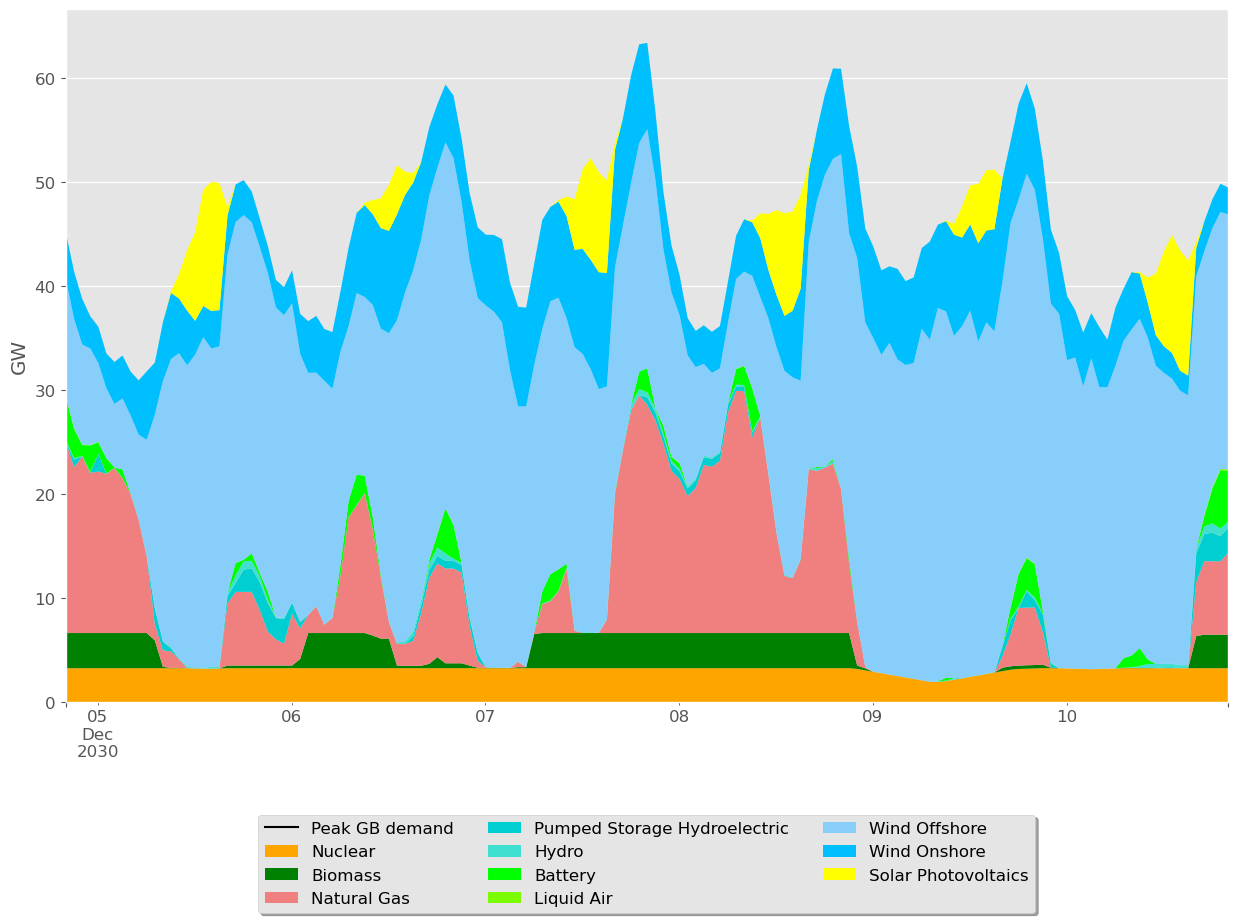

In [25]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

ax.set_ylabel("GW")

ax.set_xlabel("")

In [26]:

buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]

p_by_carrier_scotland = network.generators_t.p[df_generators_scotland.index.values].groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier_scotland = network.storage_units_t.p[df_storage_scotland.index.values].groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier_scotland[storage_by_carrier_scotland < 0] = 0

p_by_carrier_scotland = pd.concat([p_by_carrier_scotland, storage_by_carrier_scotland], axis=1)

In [27]:
network.lines_t.p0[['17', '18', '23', '24', '16']]
B6_to_scotland = network.lines_t.p0[['17', '18', '23', '24', '16']]

B6_import = B6_to_scotland.copy()
B6_export = B6_to_scotland.copy()

B6_import[B6_import > 0] = 0
B6_import = B6_import.sum(axis=1) * -1

B6_export[B6_export < 0] = 0
B6_export = B6_export.sum(axis=1) * -1
B6_export.name = 'B6 export'

Text(0.5, 0, '')

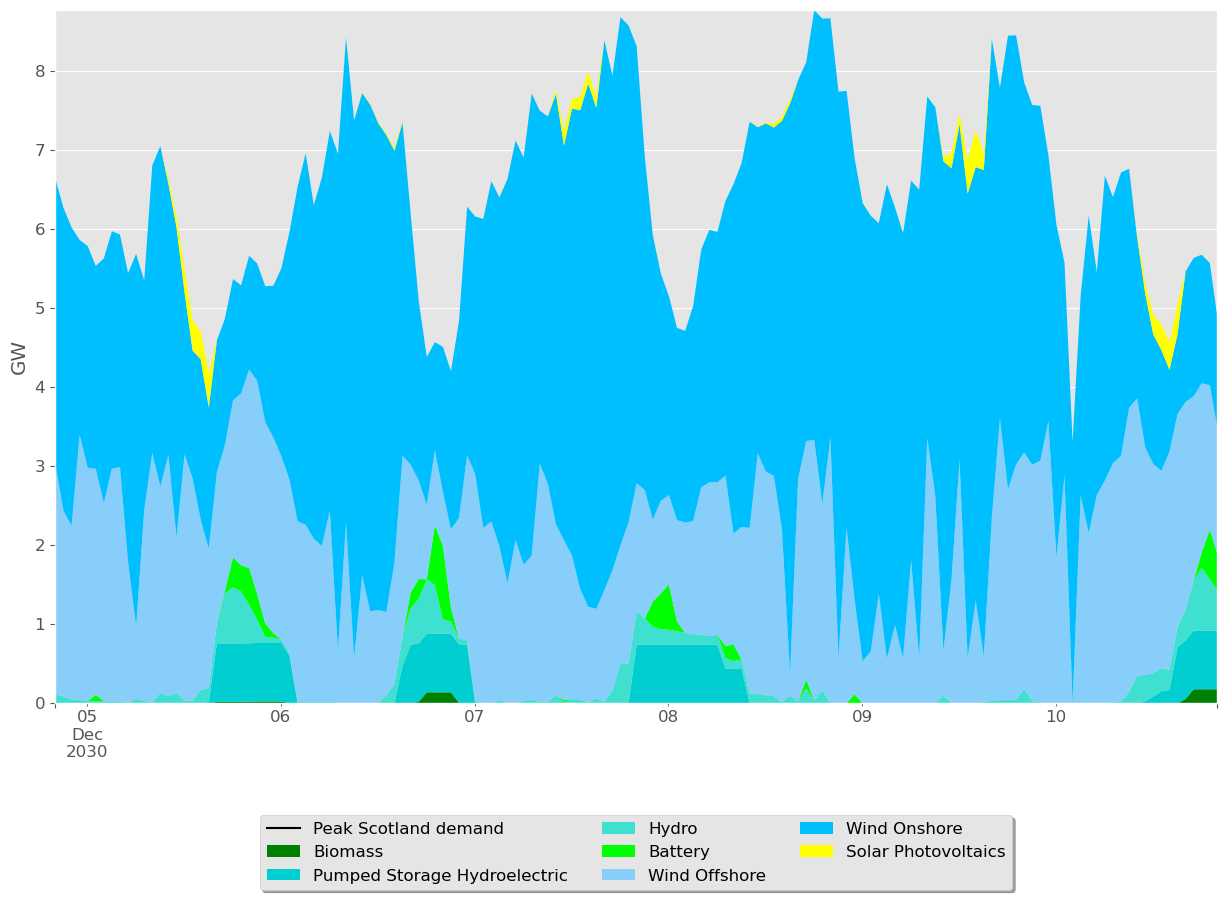

In [28]:
# group biomass stuff
p_by_carrier_scotland['Biomass'] = (
    p_by_carrier_scotland['Biomass (dedicated)'])

# add B6 flows
p_by_carrier_scotland['B6 import'] = B6_import

# rename the hydro bit
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Interconnector': 'Interconnectors Import'})

cols = ['Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load', 'B6 import'
        ]

p_by_carrier_scotland = p_by_carrier_scotland[cols]

p_by_carrier_scotland.drop(
    (p_by_carrier_scotland.max()[p_by_carrier_scotland.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier_scotland / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier_scotland.columns])

# # stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
# (B6_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# # rescale the y axis
# print(B6_export)
# ax.set_ylim(B6_export.min() / 1e3, (p_by_carrier_scotland / 1e3).sum(axis=1).max())
ax.set_ylim(0, (p_by_carrier_scotland / 1e3).sum(axis=1).max())

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak Scotland demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("GW")

ax.set_xlabel("")


## Import and export analysis

In [29]:
# GWh
df_import_export = pd.concat([B6_import, B6_export * -1], axis=1) / 1000
df_import_export.columns = ['B6 Import', 'B6 Export']
df_import_export.sum()
# df_import_export = df_import_export.groupby(df_import_export.index.to_period('M')).sum()
# df_import_export.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# df_import_export.plot(kind="bar", rot=0, figsize=(11.69, 8.27))
# plt.ylabel('TWh')
# plt.xlabel('2021')
# plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)

B6 Import    0.0
B6 Export    0.0
dtype: float64